# Active learning

In [80]:
import numpy as np

from active import split_on_ids
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from toolz.curried import curry, merge_with
from active import next_sample_gsx, next_sample_igs
from tqdm.notebook import trange, tqdm
import hdfdict
import matplotlib
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


In [99]:
def make_gp_model_matern():
    kernel = Matern(length_scale=1.0, nu=0.5)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor

def make_linear_model():
    return Pipeline(steps=(
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))


In [100]:
def train_test_split_(x_data, y_data, prop, random_state=None):
    ids = np.random.choice(len(x_data), int(prop * len(x_data)), replace=False)
    x_0, x_1 = split_on_ids(x_data, ids)
    y_0, y_1 = split_on_ids(y_data, ids)
    return x_0, x_1, y_0, y_1

In [101]:
def split(x_data, y_data, train_sizes=(0.9, 0.09), random_state=None):
    x_pool, x_, y_pool, y_ = train_test_split_(
        x_data,
        y_data,
        train_sizes[0],
        random_state=random_state
    )
    x_test, x_calibrate, y_test, y_calibrate = train_test_split_(
        x_,
        y_,
        train_sizes[1] / (1 - train_sizes[0]),
        random_state=random_state
    ) 
    return x_pool, x_test, x_calibrate, y_pool, y_test, y_calibrate

In [102]:
@curry 
def oracle_func(x_data, y_data, query_instance):
    idx, query_value = query_instance
    return query_value.reshape(1, -1), np.array([y_data[idx]]).reshape(1)

In [103]:
def query_uncertainty(model, x_pool, y_pool, batch_size):
    stds = model.predict(x_pool, return_std=True)[1]
    ids = np.argsort(stds)[::-1][:batch_size]
    return rework_pool(x_pool, y_pool, ids)

def query_random(model, x_pool, y_pool, batch_size):
    ids = np.random.choice(len(x_pool), batch_size, replace=False)
    return rework_pool(x_pool, y_pool, ids)


def evaluate_model(x_pool, x_test, x_train, y_pool, y_test, y_train, model, query_func, batch_size):
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    x_, x_pool, y_, y_pool = query_func(model, x_pool, y_pool, batch_size)
    x_train = np.vstack([x_train, x_])
    y_train = np.append(y_train, y_)
    return model, x_pool, x_train, y_pool, y_train, test_score, train_score

In [104]:

def query_helper(model, x_pool, y_pool, init_scores, update_scores, next_func):
    if not hasattr(model, 'query_data'):
        model.query_data = [], init_scores()
    labeled_samples, scores = model.query_data
    scores = update_scores(model, scores)
    next_id = next_func(labeled_samples, scores)
    model.query_data = (labeled_samples + [next_id], scores)
    x_, _, y_, _ = rework_pool(x_pool, y_pool, [next_id])
    return x_, x_pool, y_, y_pool


def gsx_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: x_pool,
        lambda m, s: s,
        next_sample_gsx
    )

def gsy_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: None,
        lambda m, s: m.predict(x_pool).reshape(-1, 1),
        next_sample_gsx
    )


def igs_query(model, x_pool, y_pool, batch_size):
    return query_helper(
        model,
        x_pool,
        y_pool,
        lambda: (x_pool, None),
        lambda m, s: (s[0], m.predict(x_pool).reshape(-1, 1)),
        next_sample_igs
    )

In [105]:
from toolz.curried import map as fmap

def merge_func(x):
    return dict(
        mean=np.mean(x, axis=0),
        std=np.std(x, axis=0),
        scores=np.array(x)
    )

def run_multiple(x_data_pca, y_data, train_sizes, learners, n_query, n_iter, batch_size):
    _ = fmap(lambda _: run_all(x_data_pca, y_data, train_sizes, learners, n_query, batch_size), trange(n_iter, position=0, desc='outer loop'))
    all_data = list(_)
    return merge_with(merge_func, *all_data)

In [106]:
def run_all(x_data_pca, y_data, train_sizes, learners, n_query, batch_size):
    data = split(x_data_pca, y_data, train_sizes)
    test_scores = dict()
    for k in tqdm(learners, position=1, desc="learner loop"):
        test_scores[k] = run(data, learners[k][0], learners[k][1], n_query, batch_size=batch_size)[1]
    return test_scores

In [107]:
def run(data, query_func, model_func, n_iter, train_sizes=(0.87, 0.004), batch_size=1):
    x_pool, x_test, x_train, y_pool, y_test, y_train = data
    print('x_train.shape', x_train.shape)
    print('x_test.shape:', x_test.shape)
    model = model_func()
    train_scores = []
    test_scores = []
    
#    for k in tqdm.tqdm(learners):
#        test_scores[k] = run(data, learners[k][0], learners[k][1], n_query)[1]
    
    for _ in trange(n_iter, position=2, desc='iter loop'):
#        model_ = model
#        model = model_func()
#        if hasattr(model_, "query_data"):
#            model.query_data = model_.query_data
        model, x_pool, x_train, y_pool, y_train, test_score, train_score  = evaluate_model(
            x_pool, x_test, x_train, y_pool, y_test, y_train,
            model, 
            query_func,
            batch_size
        )
        
        train_scores += [train_score] * batch_size
        test_scores += [test_score] * batch_size
       
    return train_scores, test_scores
    

In [108]:
def rework_pool(x_pool, y_pool, ids):
    x_, x_pool = split_on_ids(x_pool, ids)
    y_, y_pool = split_on_ids(y_pool, ids)
    return x_, x_pool, y_, y_pool

In [117]:
def plot_scores(scores, opt=None, opt_error=None, error_freq=20):

    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor']='w'
    plt.figure(figsize=(10, 8))
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14) 
    ax = plt.gca()
    matplotlib.rc('font', **dict(size=16))
    names = dict(
        uncertainty=('Uncertainty', 'solid'),
        random=("Random", 'dotted'),
        gsx=("GSX", 'dashed'),
        gsy=("GSY", 'dashdot'),
        igs=("IGS", (5, (10, 3)))
    )

    offset = 10
    for k, v in scores.items():
        y = v['mean']
        x = np.arange(len(y))
        p = ax.plot(x, y, label=names[k][0], lw=3, linestyle=names[k][1])
        e = v['std']
        xe, ye, ee = x[offset::error_freq], y[offset::error_freq], e[offset::error_freq]
        ax.errorbar(xe, ye, yerr=ee, alpha=0.5, ls='none', ecolor=p[-1].get_color(), elinewidth=3, capsize=4, capthick=3)
        offset += 5
        
    if opt is not None:
        xx = [0, 50, 100]
        yy = [opt] * len(xx)
        ee = [opt_error] * len(xx)
        p = ax.plot(xx, yy, 'k--', label='Optimal')
        ax.errorbar(xx, yy, yerr=ee, alpha=0.5, ls='none', ecolor=p[-1].get_color(), elinewidth=3, capsize=4, capthick=3)

    plt.legend(fontsize=16)
    plt.xlabel('N (queries)', fontsize=16)
    plt.ylabel(r'$R^2$', fontsize=16);
    plt.ylim(0.0, 1)
    
    return plt, ax

# Load data and run the active learning

In [122]:
data = np.load('data_pca51.npz')

In [123]:
x_data_pca = data['x_data_pca']
y_data = data['y_data']

In [126]:
learners_linear = dict(
    random=(query_random, make_linear_model),
    gsx=(gsx_query, make_linear_model),
    gsy=(gsy_query, make_linear_model),
    igs=(igs_query, make_linear_model)
)

learners_gp = dict(
    uncertainty=(query_uncertainty, make_gp_model_matern),
    random=(query_random, make_gp_model_matern),
    gsx=(gsx_query, make_gp_model_matern),
    gsy=(gsy_query, make_gp_model_matern),
    igs=(igs_query, make_gp_model_matern)
)

output = run_multiple(x_data_pca, y_data, (0.79, 0.2), learners_linear, 100, 40, 1)

outer loop:   0%|          | 0/40 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

learner loop:   0%|          | 0/4 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

x_train.shape (6, 15)
x_test.shape: (120, 15)


iter loop:   0%|          | 0/100 [00:00<?, ?it/s]

(<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <AxesSubplot:xlabel='N (queries)', ylabel='$R^2$'>)

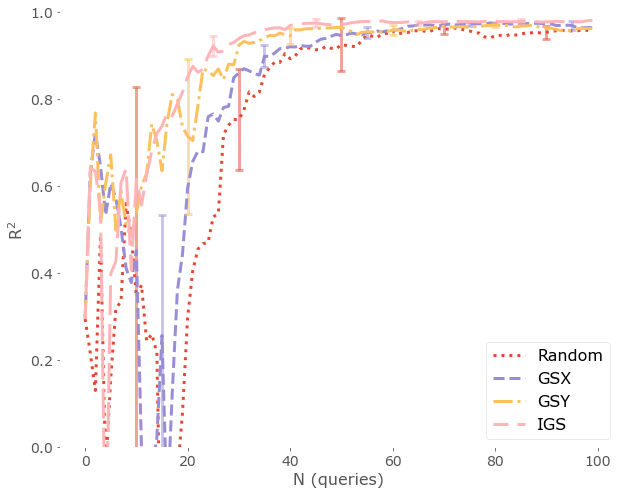

In [125]:
plot_scores(output, error_freq=20, opt=None, opt_error=0.0059322)

In [57]:
?hdfdict.dump

In [95]:
!rm output.h5

In [96]:
hdfdict.dump(output, 'output.h5')

/nix/store/d356vfcf4lrrx8rd92fz71zd2d2hinxd-python3.8-hdfdict-0.3.1/lib/python3.8/site-packages/hdfdict/hdfdict.py:22: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  yield h5py.File(hdf, *args, **kwargs)


<HDF5 file "output.h5" (mode r+)>

In [97]:
output_ = hdfdict.load('output.h5')

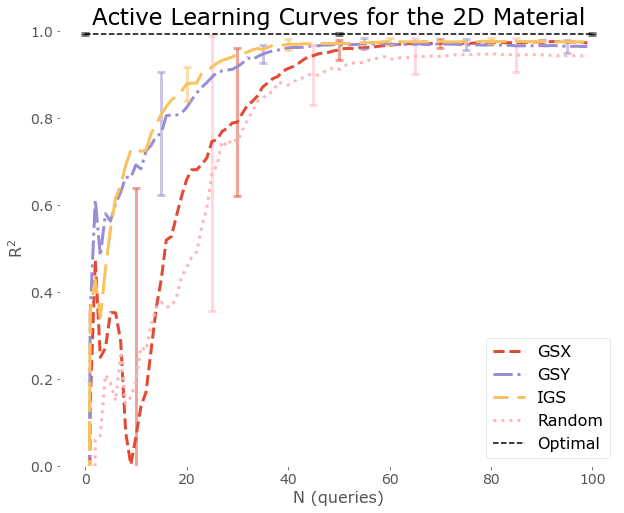

In [120]:
plt, ax = plot_scores(output_, error_freq=20, opt=0.993, opt_error=0.0014)
plt.title('Active Learning Curves for the 2D Material')
plt.savefig('plot2d.png')